# Customized Graph Attention Network
This notebook uses PyTorch Geometric to implement the Graph Attention Network (GAT) proposed in [Graph Attention Networks](https://arxiv.org/abs/1710.10903). PyG comes with a GAT model but we define our own here to illustrate how to develop a graph nerual network model with basic functions in PyG and PyTorch. We train the model on the Cora dataset from [PyG datasets](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid) with TigerGraph as the data store. The dataset contains 2708 machine learning papers and 10556 citation links between the papers.  Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from a dictionary. The dictionary consists of 1433 unique words. Each paper is classified into one of seven classes based on the topic. The goal is to predict the class of each vertex in the graph.

The following libraries are required to run this notebook. Uncomment to install them if necessary. You might need to restart the kernel after installing

In [ ]:
#!pip install torch
#!pip install tgml[pyg]
#!pip install tensorboard # If you use tensorboard for visualization later

## Table of Contents
* [Data Processing](#data_processing) 
* [Model definition](#def_model)
* [Train on whole graph](#train_whole)  
* [Train on neighborhood subgraphs](#train_subgraph)  
* [Inference](#inference)

## Data Processing <a name="data_processing"></a>

Here we assume the dataset is already ingested into the TigerGraph database. If not, please refer to the example on data ingestion first. Since the dataset already has a split of vertices into train/validation/test sets, we don't need to do so. But we still include the code below for general use cases.

### Connect to TigerGraph

In [ ]:
from tgml.data import TigerGraph

tgraph = TigerGraph(
    host="http://127.0.0.1", # Change the address to your database server's
    graph="Cora",
    username="tigergraph",
    password="tigergraph",
    token_auth=False # Whether to use token authentication. If True, token authentication must be turned on in the TigerGraph database server.
)

In [ ]:
# Basic metadata about the graph such as schema.
tgraph.info()

In [ ]:
tgraph.number_of_vertices()

In [ ]:
tgraph.number_of_edges()

### Train/validation/test split

In [ ]:
# The code in this cell is commented out because there is no need to split the vertices into 
# training/validation/test sets, as the split is already done in the original dataset. 
# See notebook 1_data_processing for examples on the split function.

#from tgml.utils import split_vertices
#split_vertices(tgraph, train_mask=0.8, val_mask=0.1, test_mask=0.1)

In [ ]:
print(
    "Number of vertices in training set:",
    tgraph.number_of_vertices(filter_by="train_mask"),
)
print(
    "Number of vertices in validation set:",
    tgraph.number_of_vertices(filter_by="val_mask"),
)
print(
    "Number of vertices in test set:", tgraph.number_of_vertices(filter_by="test_mask")
)

## Define Graph Attention Network <a name="def_model"></a>

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(
        self, num_features, num_layers, out_dim, dropout, hidden_dim, num_heads
    ):
        super().__init__()
        self.dropout = dropout
        self.layers = torch.nn.ModuleList()
        for i in range(num_layers):
            in_units = num_features if i == 0 else hidden_dim * num_heads
            out_units = out_dim if i == (num_layers - 1) else hidden_dim
            heads = 1 if i == (num_layers - 1) else num_heads
            self.layers.append(
                GATConv(in_units, out_units, heads=heads, dropout=dropout)
            )

    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for layer in self.layers[:-1]:
            x = layer(x, edge_index)
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.layers[-1](x, edge_index)
        return x

## Train on whole graph <a name="train_whole"></a>
We first train the model on the whole graph. This will **NOT** work when the graph is large. See the section of training on subgraphs for real use. However, we still include this example for illustration purpose. Hyperparameters for the model and training environment are defined below.

In [ ]:
# Hyperparameters
hp = {
    "num_heads": 8,
    "hidden_dim": 8,
    "num_layers": 2,
    "dropout": 0.6,
    "lr": 0.01,
    "l2_penalty": 5e-4,
}

### Construct graph loader

The `GraphLoader` will get the whole graph from database all at once. (See the tutorial on dataloaders for details.) 

In [ ]:
from tgml.dataloaders import GraphLoader

graph_loader = GraphLoader(
    graph=tgraph,
    v_in_feats="x",
    v_out_labels="y:int",
    v_extra_feats="train_mask:bool,val_mask:bool,test_mask:bool",
    output_format="PyG",
)

In [ ]:
# Get the whole graph from the loader in PyG format
data = graph_loader.data

data

### Construct model and optimizer

We build a GAT model with 2 GATConv layers and 8 attention heads. We use the Adam optimizer with a learning rate of 0.01.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GAT(
    num_features=1433,
    num_layers=hp["num_layers"],
    out_dim=7,
    dropout=hp["dropout"],
    hidden_dim=hp["hidden_dim"],
    num_heads=hp["num_heads"],
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=hp["lr"], weight_decay=hp["l2_penalty"])

### Train the model

In [ ]:
from datetime import datetime

from tgml.metrics import Accuracy
from torch.utils.tensorboard import SummaryWriter

In [ ]:
log_dir = "logs/cora/gat2/wholegraph/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_log = SummaryWriter(log_dir)
logs = {}
data = data.to(device)
for epoch in range(20):
    # Train
    model.train()
    acc = Accuracy()
    # Forward pass
    out = model(data)
    # Calculate loss
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Evaluate
    val_acc = Accuracy()
    with torch.no_grad():
        pred = out.argmax(dim=1)
        acc.update(pred[data.train_mask], data.y[data.train_mask])
        valid_loss = F.cross_entropy(out[data.val_mask], data.y[data.val_mask])
        val_acc.update(pred[data.val_mask], data.y[data.val_mask])
    # Logging
    logs["loss"] = loss.item()
    logs["val_loss"] = valid_loss.item()
    logs["acc"] = acc.value
    logs["val_acc"] = val_acc.value
    print(
        "Epoch: {:02d}, Train Loss: {:.4f}, Valid Loss: {:.4f}, Train Accuracy: {:.4f}, Valid Accuracy: {:.4f}".format(
            epoch, logs["loss"], logs["val_loss"], logs["acc"], logs["val_acc"]
        )
    )
    tb_log.add_scalars(
        "Loss", {"Train": logs["loss"], "Validation": logs["val_loss"]}, epoch
    )
    tb_log.add_scalars(
        "Accuracy", {"Train": logs["acc"], "Validation": logs["val_acc"]}, epoch
    )
    tb_log.flush()

### Visualize training status

We can use tensorboard to visualize and track training status. As the cell above is running, run the code below will start a tensorboard server in the background. 
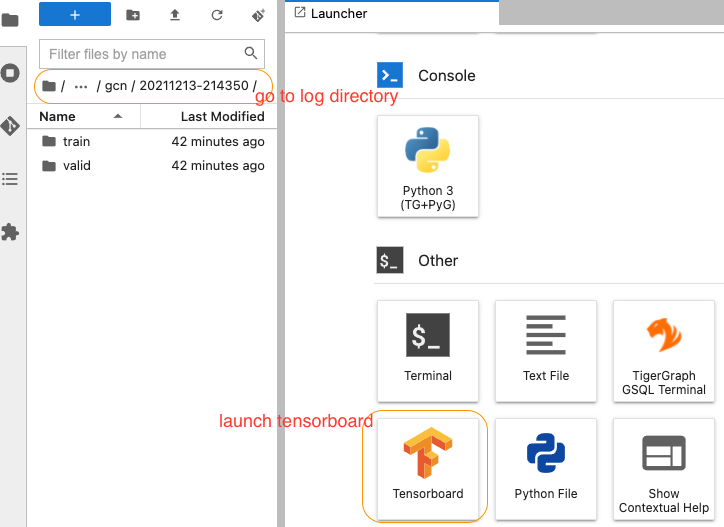

In [ ]:
import os
os.system("tensorboard --logdir logs --port 6006 --bind_all &")

Once the tensorboard service is running, go to `localhost:6006` in your browser and you should see all the pretty plots as below. For details on using tensorboard, please refer to its [official doc](https://www.tensorflow.org/tensorboard/get_started).

![Screen Shot 2022-02-09 at 5.02.00 PM.png](attachment:8dfeadc7-e937-466a-aa4a-41477d5bff59.png)
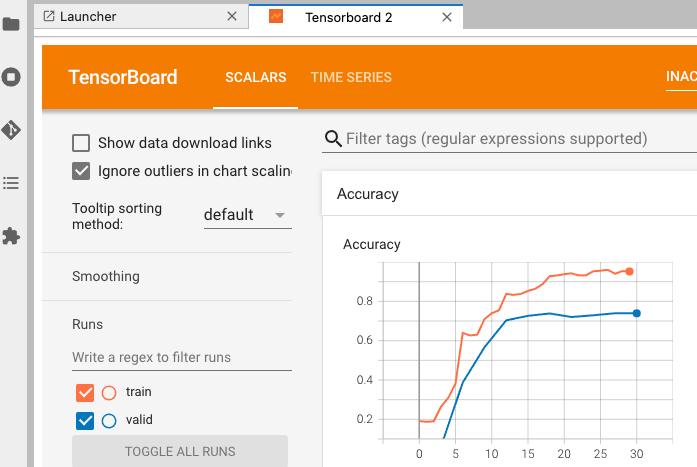

### Test the model

In [ ]:
model.eval()
acc = Accuracy()
with torch.no_grad():
    pred = model(data).argmax(dim=1)
    acc.update(pred[data.test_mask], data.y[data.test_mask])
print("Accuracy: {:.4f}".format(acc.value))

## Train on Neighborhood Subgraphs <a name="train_subgraph"></a>
Alternatively, we train the model on the neighborhood subgraphs. Each subgraph contains the 2 hop neighborhood of certain seed vertices. This method  will allow us to train the model on graphs that are way larger than the CORA dataset because we don't load the whole graph into memory all at once. 

We will use the same parameters as before, but we will use the NeighborLoader to load subgraphs. Once we finish iterating over all the subgraphs generated by the loader, it is guaranteed to cover all vertices in the graph (except for those filtered by a user provided mask). 

In [ ]:
# Hyperparameters
hp = {
    "batch_size": 64,
    "num_neighbors": 10,
    "num_hops": 2,
    "num_heads": 8,
    "hidden_dim": 8,
    "num_layers": 2,
    "dropout": 0.6,
    "lr": 0.01,
    "l2_penalty": 5e-4,
}

### Construct neighborhood subgraph loader

In [ ]:
from tgml.dataloaders import NeighborLoader

Here we construct 3 subgraph loaders. The `train_loader` only uses vertices in the training set as seeds, the `valid_loader` only uses vertices in the validation set, and the `test_loader` only uses vertices in the test set.

In [ ]:
train_loader = NeighborLoader(
    graph=tgraph,
    tmp_id="tmp_id",
    v_in_feats="x",
    v_out_labels="y:int",
    v_extra_feats="train_mask:bool,val_mask:bool,test_mask:bool",
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    shuffle=True,
    filter_by="train_mask",
)

In [ ]:
valid_loader = NeighborLoader(
    graph=tgraph,
    tmp_id="tmp_id2",
    v_in_feats="x",
    v_out_labels="y:int",
    v_extra_feats="train_mask:bool,val_mask:bool,test_mask:bool",
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    shuffle=False,
    filter_by="val_mask",
)

In [ ]:
test_loader = NeighborLoader(
    graph=tgraph,
    tmp_id="tmp_id3",
    v_in_feats="x",
    v_out_labels="y:int",
    v_extra_feats="train_mask:bool,val_mask:bool,test_mask:bool",
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    shuffle=False,
    filter_by="test_mask",
)

### Construct model and optimizer

We build a GAT model with 2 GATConv layers and 8 attention heads. We use the Adam optimizer with a learning rate of 0.01.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GAT(
    num_features=1433,
    num_layers=hp["num_layers"],
    out_dim=7,
    dropout=hp["dropout"],
    hidden_dim=hp["hidden_dim"],
    num_heads=hp["num_heads"],
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(), lr=hp["lr"], weight_decay=hp["l2_penalty"]
)

### Train the model

In [ ]:
from datetime import datetime

from tgml.metrics import Accumulator, Accuracy
from torch.utils.tensorboard import SummaryWriter

In [ ]:
log_dir = "logs/cora/gat2/subgraph/" + datetime.now().strftime("%Y%m%d-%H%M%S")
train_log = SummaryWriter(log_dir+"/train")
valid_log = SummaryWriter(log_dir+"/valid")
global_steps = 0
logs = {}
for epoch in range(10):
    # Train
    model.train()
    epoch_train_loss = Accumulator()
    epoch_train_acc = Accuracy()
    for bid, batch in enumerate(train_loader):
        batchsize = batch.x.shape[0]
        batch.to(device)
        # Forward pass
        out = model(batch)
        # Calculate loss
        loss = F.cross_entropy(out[batch.train_mask], batch.y[batch.train_mask])
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss.update(loss.item() * batchsize, batchsize)
        # Predict on training data
        with torch.no_grad():
            pred = out.argmax(dim=1)
            epoch_train_acc.update(pred[batch.train_mask], batch.y[batch.train_mask])
        # Log training status after each batch
        logs["loss"] = epoch_train_loss.mean
        logs["acc"] = epoch_train_acc.value
        print(
            "Epoch {}, Train Batch {}, Loss {:.4f}, Accuracy {:.4f}".format(
                epoch, bid, logs["loss"], logs["acc"]
            )
        )
        train_log.add_scalar("Loss", logs["loss"], global_steps)
        train_log.add_scalar("Accuracy", logs["acc"], global_steps)
        train_log.flush()
        global_steps += 1
    # Evaluate
    model.eval()
    epoch_val_loss = Accumulator()
    epoch_val_acc = Accuracy()
    for batch in valid_loader:
        batchsize = batch.x.shape[0]
        batch.to(device)
        with torch.no_grad():
            # Forward pass
            out = model(batch)
            # Calculate loss
            valid_loss = F.cross_entropy(out[batch.val_mask], batch.y[batch.val_mask])
            epoch_val_loss.update(valid_loss.item() * batchsize, batchsize)
            # Prediction
            pred = out.argmax(dim=1)
            epoch_val_acc.update(pred[batch.val_mask], batch.y[batch.val_mask])
    # Log testing result after each epoch
    logs["val_loss"] = epoch_val_loss.mean
    logs["val_acc"] = epoch_val_acc.value
    print(
        "Epoch {}, Valid Loss {:.4f}, Valid Accuracy {:.4f}".format(
            epoch, logs["val_loss"], logs["val_acc"]
        )
    )
    valid_log.add_scalar("Loss", logs["val_loss"], global_steps)
    valid_log.add_scalar("Accuracy", logs["val_acc"], global_steps)
    valid_log.flush()

### Visualize training status

We can use tensorboard to visualize and track training status. As the cell above is running, run the code below will start a tensorboard server in the background if you haven't done so. If you have already started a tensorboard server, skip the cell below or you will get an error complaining that the port is in use. 
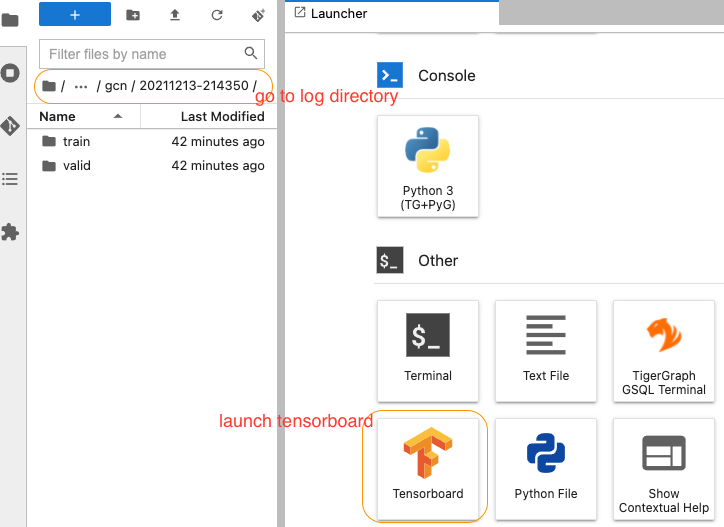

In [ ]:
import os
os.system("tensorboard --logdir logs --port 6006 --bind_all &")

Once the tensorboard service is running, go to `localhost:6006` in your browser and you should see all the pretty plots as below. For details on using tensorboard, please refer to its [official doc](https://www.tensorflow.org/tensorboard/get_started).
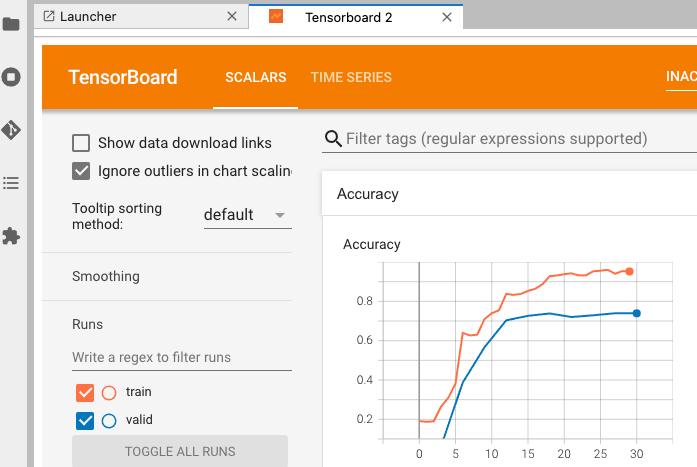

![Screen Shot 2022-02-09 at 5.02.00 PM.png](attachment:03f04eb0-e18a-4beb-a8ff-79cbad34f469.png)

### Test the model

In [ ]:
model.eval()
acc = Accuracy()
for batch in test_loader:
    batch.to(device)
    with torch.no_grad():
        pred = model(batch).argmax(dim=1)
        acc.update(pred[batch.test_mask], batch.y[batch.test_mask])
print("Accuracy: {:.4f}".format(acc.value))

## Inference <a name="inference"></a>

Finally, we use the trained model for node classification. At this stage, we typically do inference/prediction for specific nodes instead of random batches, so we will create a new data loader and set it to inference mode.  

In [ ]:
infer_loader = NeighborLoader(
    graph=tgraph,
    v_in_feats="x",
    output_format="PyG",
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    shuffle=False,
)

In [ ]:
# Set the data loader to inference mode. 
# This is a key step as the loaders are in training mode by default.
infer_loader.inference()

In [ ]:
# Fetch specific nodes by their IDs and do prediction. 
# Each node is represented by a dict with two mandatory keys: id and type.
input_nodes = [{"id": 7, "type": "Paper"}, 
               {"id": 999, "type": "Paper"}]
data = infer_loader.fetch(input_nodes)

In [ ]:
# The returned data are the neighborhood subgraphs of the input nodes.
# The original IDs of the nodes in the subgraphs are stored in the 
# `primary_id` attribute.
data

In [ ]:
# Predict. Predictions for both the input nodes and others in their 
# neighborhoods are generated.
model.eval()
pred = model(data).argmax(dim=1)
print("ID: Label")
for i,j in zip(data.primary_id, pred):
    print("{}:{}".format(i.item(), j.item()))